In [1]:
from __future__ import print_function
import pandas as pd
import numpy as np
from PIL import Image
import time
import matplotlib.pyplot as plt
import pickle

import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset
from torch.utils.data import Dataset

import argparse
import torch
# import torch.tensor as tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import time
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.autograd import Variable
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

from torchvision import models
#from resnet import resnet50
#from res2net import res2net50_48w_2s,res2net50_26w_8s,res2net50

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
#from resnet import resnet50


In [2]:
def tensor(x):
    return torch.tensor(x)

In [3]:
# X[:,0:16] dataset_pcell_csi_rsrp
# X[:,17:32]dataset_pcell_csi_rsrp_std
# X[:,33:34]dataset_ri
# X[:,34:35]dataset_mcs
# X[:,35:36]dataset_cqi
# X[:,36:42]dataset_ncell_ss_rsrp
# X[:,42:47]dataset_ncell_ss_rsrp_std

# y[:,0] SE  
# y[:,1] (I+N)a
# y[:,2] (I+N)b
# y[:,3] SINR(CQI)
# y是归一化后的数据，归一化方式，y=y_original/y_max
#后面提供y_max是为了方便将归一化后的y_true和y_pred还原
# y_max[0] max(y[:,0]) 
# y_max[1] min(y[:,1])
# y_max[2] min(y[:,2])
# y_max[3] max(y[:,3]) 

with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl','rb') as f:
    X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)

In [4]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(814140, 48) (814140, 4) (83192, 48) (83192, 4) (102525, 48) (102525, 4)


### Dataset process for label training - split original dataset and transfer labels

In [5]:
def label_transfer(labels,transfer_pairs):
    for pair in transfer_pairs:
        print(labels==pair[0])
        labels[labels==pair[0]] = pair[1]
    return labels

In [6]:
def y2label(y_ori,y_max):
    labels = np.zeros(y_ori.shape).astype(np.int32)+3
    
    labels[y_ori*y_max <= 2250] = 2
    labels[y_ori*y_max <= 1850] = 1
    labels[y_ori*y_max <= 1350] = 0
    
    return labels

In [7]:
X_train = np.hstack((X_train[:,0:32],X_train[:,36:42]))
y_train = y_train[:,0]
X_val = np.hstack((X_val[:,0:32],X_val[:,36:42]))
y_val = y_val[:,0]
X_test = np.hstack((X_test[:,0:32],X_test[:,36:42]))
y_test = y_test[:,0]
ylabel_train = y2label(y_train,y_max[0])
ylabel_val = y2label(y_val,y_max[0])
ylabel_test = y2label(y_test,y_max[0])

In [8]:
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape,X_test.shape,y_test.shape)

(814140, 38) (814140,) (83192, 38) (83192,) (102525, 38) (102525,)


In [59]:
counts = [sum(ylabel_train == 0),sum(ylabel_train == 1),sum(ylabel_train == 2),sum(ylabel_train == 3)]

In [60]:
y_train

array([0.05666327, 0.05970148, 0.06275808, ..., 0.27547748, 0.26365272,
       0.25167538])

<BarContainer object of 4 artists>

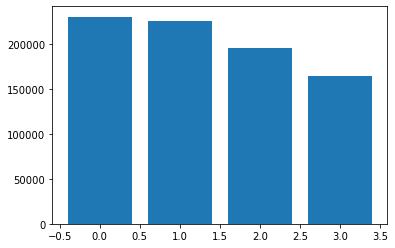

In [103]:
plt.bar(range(len(counts)),counts)

In [9]:
class Train_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_train = np.hstack((X_train[:,0:32],X_train[:,36:42]))
        self.y_train = y_train[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_train.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_train = tensor(self.X_train[idx,:])
        label = tensor(self.y_train[idx])
    
        return x_train,label

class Val_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_val = np.hstack((X_val[:,0:32],X_val[:,36:42]))
        self.y_val = y_val[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_val.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_val = tensor(self.X_val[idx,:])
        label = tensor(self.y_val[idx])
    
        return x_val,label

class Test_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_test = np.hstack((X_test[:,0:32],X_test[:,36:42]))
        self.y_test = y_test[:,0]
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_test.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_test = tensor(self.X_test[idx,:])
        label = tensor(self.y_test[idx])
    
        return x_test,label

In [10]:
class Train_Label_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_train = np.hstack((X_train[:,0:32],X_train[:,36:42]))
        self.y_train = y2label(y_train[:,0],y_max[0])
        
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_train.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_train = tensor(self.X_train[idx,:])
        label = tensor(self.y_train[idx])
    
        return x_train,label

class Val_Label_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_val = np.hstack((X_val[:,0:32],X_val[:,36:42]))
        self.y_val = y2label(y_val[:,0],y_max[0])
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_val.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_val = tensor(self.X_val[idx,:])
        label = tensor(self.y_val[idx])
    
        return x_val,label

class Test_Label_Dataset(Dataset):
    def __init__(self, path="DataSet_2021_9_6_filter_combine_normalize_cd.pkl",transform=None, target_transform=None):
        
        with open('DataSet_2021_9_6_filter_combine_normalize_cd.pkl', 'rb') as f:
            X_train,y_train,X_val,y_val,X_test,y_test,y_max,ff = pickle.load(f)
        
        self.X_test = np.hstack((X_test[:,0:32],X_test[:,36:42]))
        self.y_test = y2label(y_test[:,0],y_max[0])
        
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return self.X_test.shape[0]

    def __getitem__(self, idx):
        
        #image = torchvision.transforms.functional.to_tensor(np.array(image.resize((240,320),Image.BILINEAR)))
        #label = tensor(self.label2vec(label))
        
        x_test = tensor(self.X_test[idx,:])
        label = tensor(self.y_test[idx])
    
        return x_test,label

In [11]:
def train_classifier(train_loader, classifier, criterion, optimizer,show_interval = 3000):
    classifier.train()
    loss_ = 0.0
    losses = []
    acc = []
    # f1_list = []
    for i, (images, labels) in enumerate(train_loader):
        labels = torch.tensor(np.array(labels))
        images, labels = images.to(torch.float32).to(device), labels.to(torch.int64).to(device)
        
        logits = classifier(images)
        loss = criterion(logits,labels)
        loss = loss.requires_grad_()
        
        if i % show_interval == 0:
            print(i*args.batch_size)
            # acc_new = acc_cal(logits.detach(),labels.numpy())
            acc_new = acc_f1_cal_multi(logits.detach(),labels.numpy())
            acc += np.mean(acc_new)
            # f1_list += [f1]
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
        
    return torch.stack(losses).mean().item(),np.mean(acc)

def train_classifier_cnn(train_loader, classifier, criterion, optimizer,show_interval = 3000):
    classifier.train()
    loss_ = 0.0
    losses = []
    acc = []
    # f1_list = []
    for i, (images, labels) in enumerate(train_loader):
        labels = torch.tensor(np.array(labels))
        images, labels = images.to(torch.float32).to(device), labels.to(torch.int64).to(device)
        
        images = images.reshape((images.shape[0],1,images.shape[1]))
        logits = classifier(images)
        logits = logits.reshape((logits.shape[0],logits.shape[2]))
        loss = criterion(logits,labels)
        loss = loss.requires_grad_()
        
        if i % show_interval == 0:
            print(i*args.batch_size)
            # acc_new = acc_cal(logits.detach(),labels.numpy())
            # acc_new,_ = acc_f1_cal_multi(logits.detach(),labels.numpy())
            # acc += np.mean(acc_new)
            # f1_list += [f1]
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.detach())
        
    return torch.stack(losses).mean().item()
    
def test_classifier(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    acc = []
    logits_all = np.zeros((0,4))
    labels_all = np.zeros((0))
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            labels = torch.tensor(np.array(labels))
            images, labels = images.to(torch.float32).to(device), labels.to(torch.int64).to(device)

            logits = classifier(images)
            # print(logits.shape,labels.shape)
            logits_all = np.vstack((logits_all,logits.detach()))
            labels_all = np.hstack((labels_all,labels))
            # acc_new = acc_cal(logits,labels)
            # acc += [acc_new]
            
            loss = criterion(logits,labels)
            losses.append(loss.detach())
        
        test_loss = torch.stack(losses).mean().item()
    return test_loss,acc_f1_cal_multi(logits_all,labels_all)

def test_classifier_cnn(test_loader, classifier, criterion, print_ind_classes=True):
    classifier.eval()
    losses = []
    acc = []
    logits_all = np.zeros((0,4))
    labels_all = np.zeros((0))
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            labels = torch.tensor(np.array(labels))
            images, labels = images.to(torch.float32).to(device), labels.to(torch.int64).to(device)

            images = images.reshape((images.shape[0],1,images.shape[1]))
            logits = classifier(images)
            logits = logits.reshape((logits.shape[0],logits.shape[2]))
            # print(logits.shape,labels.shape)
            logits_all = np.vstack((logits_all,logits.detach().cpu()))
            labels_all = np.hstack((labels_all,labels.cpu()))
            # acc_new = acc_cal(logits,labels)
            # acc += [acc_new]
            
            loss = criterion(logits,labels)
            losses.append(loss.detach())
        
        test_loss = torch.stack(losses).mean().item()
    return test_loss,acc_f1_cal_multi(logits_all,labels_all)

def acc_cal(logits,labels,show = False):
    pred_labels = np.argmax(logits,1)
    pred_flags = pred_labels == labels
    acc = np.sum(pred_flags)/pred_labels.shape[0]
    if(show):
        print(pred_labels)
    return acc

def acc_f1_cal_multi(logits,labels):
    # print(logits.shape,labels.shape)
    labels = labels.astype(np.int32)
    logits = np.argmax(logits,1)
    f1 = f1_score(logits,labels,average=None)
    label_set = set([0,1,2,3])
    acc = np.zeros((len(label_set)))
    for label in label_set:
        index = labels == label
        print(label,np.sum(index))
        acc[label] = np.sum(logits[index] == labels[index])/(len(labels[index]))
    return acc,f1

### Hyper Parameters Settings

In [12]:
class paras():
    def __init__(self):
        self.batch_size = None
        self.classes = None

In [13]:
args = paras()
args.batch_size = 128
#args.classes = 20

### Dataloader Initial

In [14]:
# train_dataset = Train_Dataset()
# val_dataset = Val_Dataset()
# test_dataset = Test_Dataset()

train_label_dataset = Train_Label_Dataset()
val_label_dataset = Val_Label_Dataset()
test_label_dataset = Test_Label_Dataset()

In [15]:
# train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=False)
# val_dataloader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=args.batch_size, shuffle=True)

In [16]:
train_label_dataloader = DataLoader(train_label_dataset, batch_size=args.batch_size, shuffle=False)
val_label_dataloader = DataLoader(val_label_dataset, batch_size=args.batch_size, shuffle=True)
test_label_dataloader = DataLoader(test_label_dataset, batch_size=args.batch_size, shuffle=True)

### Model Initialize

In [17]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [189]:
class MLP_BN(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.BN1 = nn.BatchNorm1d(2*input_size)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.BN2 = nn.BatchNorm1d(4*input_size)
        
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.BN3 = nn.BatchNorm1d(input_size)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        self.BN4 = nn.BatchNorm1d(8)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)
        x = self.BN1(F.relu(self.fc1(x)))
        x = self.BN2(F.relu(self.fc2(x)))
        x = self.BN3(F.relu(self.fc3(x)))
        x = self.BN4(F.relu(self.fc4(x)))
        x = F.relu(self.fc5(x))
        
        return x
    
class DeepMLP(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, 8*input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(8*input_size, input_size)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(input_size, input_size//4)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        self.fc6 = nn.Linear(input_size//4, output_size)
        nn.init.kaiming_normal_(self.fc6.weight)
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x0 = torch.tensor(x).to(torch.float32)
        x = nn.LeakyReLU(0.3)(self.fc1(x0))
        x = nn.LeakyReLU(0.2)(self.fc2(x))
        x = nn.LeakyReLU(0.18)(self.fc3(x))
        
        x = nn.LeakyReLU(0.15)(self.fc4(x))+x0 #residual here
        
        x = nn.LeakyReLU(0.1)(self.fc5(x))
        x = torch.sigmoid(self.fc6(x))
        
        return x    
class TestMLP(nn.Module):
    def __init__(self, input_size,output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        
        return x

class MLP1DCNN(nn.Module):
    # 两层卷积 + MLP
    def __init__(self, input_size,output_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1,1,5,padding = 2)
        self.conv2 = nn.Conv1d(1,1,3,padding = 1)
        self.conv3 = nn.Conv1d(1,1,7,padding = 3)
        self.conv4 = nn.Conv1d(3,1,5,padding = 2)
        
        self.fc1 = nn.Linear(38, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)

        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x_sum = torch.cat((x1,x2,x3),axis = 1)
        x = self.conv4(x_sum)
#         x = self.conv2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = F.relu(self.fc5(x))

        return x

class MLP1DCNN_v1(nn.Module):
    # 两层卷积 + MLP
    def __init__(self, input_size,output_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1,1,3,padding = 1)
        self.conv2 = nn.Conv1d(1,1,5,padding = 2)
        self.conv3 = nn.Conv1d(1,1,7,padding = 3)
        # self.conv4 = nn.Conv1d(1,1,9,padding = 4)
        # self.conv5 = nn.Conv1d(1,1,11,padding = 5)
        

        # self.conv4 = nn.Conv1d(3,1,5,padding = 2)
        
        
        self.fc1 = nn.Linear(38, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)

        x1 = self.conv1(x)
        x2 = self.conv2(x)
        x3 = self.conv3(x)
        x4 = self.conv4(x)
        x5 = self.conv5(x)
        # x_sum = torch.cat((x1,x2,x3),axis = 1)
        # x = self.conv4(x_sum)+x
        x = x1 + x2 + x3
#         x = self.conv2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = F.relu(self.fc5(x))

        return x

class MLP1DCNN_v2(nn.Module):
    # 两层卷积 + MLP
    def __init__(self, input_size,output_size):
        super().__init__()
        self.conv1 = nn.Conv1d(1,1,3,padding = 1)
        self.conv2 = nn.Conv1d(1,1,5,padding = 2)
        self.conv3 = nn.Conv1d(1,1,7,padding = 3)
        self.conv4 = nn.Conv1d(1,1,9,padding = 4)
        self.conv5 = nn.Conv1d(1,1,11,padding = 5)
        nn.init.kaiming_normal_(self.conv1.weight)
        nn.init.kaiming_normal_(self.conv2.weight)
        nn.init.kaiming_normal_(self.conv3.weight)
        nn.init.kaiming_normal_(self.conv4.weight)
        nn.init.kaiming_normal_(self.conv5.weight)

        # self.conv4 = nn.Conv1d(3,1,5,padding = 2)
        
        
        self.fc1 = nn.Linear(38, 2*input_size)
        nn.init.kaiming_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(2*input_size, 4*input_size)
        nn.init.kaiming_normal_(self.fc2.weight)
        
        self.fc3 = nn.Linear(4*input_size, input_size)
        nn.init.kaiming_normal_(self.fc3.weight)
        
        self.fc4 = nn.Linear(input_size, 8)
        nn.init.kaiming_normal_(self.fc4.weight)
        
        self.fc5 = nn.Linear(8, output_size)
        nn.init.kaiming_normal_(self.fc5.weight)
        
        
    
    def forward(self, x):
        # forward always defines connectivity
        #x = flatten(x)
        #scores = self.fc2(F.relu(self.fc1(x)))
        #print(x.shape)
        x = torch.tensor(x).to(torch.float32)

        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(x))
        x3 = F.relu(self.conv3(x))
        x4 = self.conv4(x)
        x5 = self.conv5(x)
        # x_sum = torch.cat((x1,x2,x3),axis = 1)
        # x = self.conv4(x_sum)+x
        x = x1 + x2 + x3
#         x = self.conv2(x)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))

        x = F.relu(self.fc5(x))

        return x

model = DeepMLP(X_train.shape[1],1)
classifier = model.to(device)

criterion = torch.nn.L1Loss()
criterion = criterion.to(device)

In [190]:
# label_classifier = torch.load("label_classifier.pt")

In [191]:
# label classifier model
model = MLP1DCNN_v2(X_train.shape[1],4)
classifier = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)

### Optimizer Settings

In [192]:
lr = 0.001
moment = 0.8
epoch_sum = 0

# optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, classifier.parameters()), lr=lr)
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, classifier.parameters()), lr=lr, momentum=moment)

In [193]:
if epoch_sum == 0:
    train_loss_list = []
    val_loss_list = []
    val_f1_list = []
    time_list = []

In [194]:
# Train the Label Classifier Model
NUM_EPOCHS = 5
TEST_FREQUENCY = 1
time_start = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    time_epoch_start = time.time()
    print("Starting epoch number " + str(epoch_sum))
    train_loss = train_classifier_cnn(train_label_dataloader, classifier, criterion, optimizer)
    train_loss_list += [train_loss]
    print("Loss for Training on Epoch " +str(epoch_sum) + " is "+ str(train_loss))
    
    #plt.plot(train_loss_list)
    time_epoch_end = time.time()
    time_one_epoch = time_epoch_end - time_epoch_start
    time_list += [time_one_epoch]
    print("Time for epoch {} is {}".format(epoch_sum,time_one_epoch))
    
    
    if(epoch_sum%TEST_FREQUENCY==0):
        val_loss= test_classifier_cnn(val_label_dataloader, classifier, criterion)
        val_loss_list += [val_loss]
        print('Evaluating classifier')
        print("Loss for validation on Epoch"+str(epoch_sum)+" is "+str(val_loss))
    
    epoch_sum += 1
    
    
    

Starting epoch number 0
0


D:\Anaconda\envs\CVenv\lib\site-packages\ipykernel_launcher.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


384000
768000
Loss for Training on Epoch 0 is 1.2052440643310547
Time for epoch 0 is 57.331459283828735
0 10949
1 32298
2 26425
3 13520
Evaluating classifier
Loss for validation on Epoch0 is (1.3475909233093262, (array([0.        , 0.32806985, 0.53248817, 0.60747041]), array([0.        , 0.40728   , 0.43427002, 0.42555507])))
Starting epoch number 1
0


D:\Anaconda\envs\CVenv\lib\site-packages\ipykernel_launcher.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


384000
768000
Loss for Training on Epoch 1 is 1.1824396848678589
Time for epoch 1 is 61.961254835128784
0 10949
1 32298
2 26425
3 13520
Evaluating classifier
Loss for validation on Epoch1 is (1.326151728630066, (array([0.        , 0.32048424, 0.45483444, 0.65066568]), array([0.        , 0.40224614, 0.39347214, 0.41033654])))
Starting epoch number 2
0


D:\Anaconda\envs\CVenv\lib\site-packages\ipykernel_launcher.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


384000
768000
Loss for Training on Epoch 2 is 1.1734293699264526
Time for epoch 2 is 61.21123433113098
0 10949
1 32298
2 26425
3 13520
Evaluating classifier
Loss for validation on Epoch2 is (1.322283148765564, (array([0.00136999, 0.31794538, 0.4571807 , 0.66309172]), array([0.0027243 , 0.3986413 , 0.39499109, 0.42009325])))
Starting epoch number 3
0


D:\Anaconda\envs\CVenv\lib\site-packages\ipykernel_launcher.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


384000
768000
Loss for Training on Epoch 3 is 1.1676876544952393
Time for epoch 3 is 65.29151248931885
0 10949
1 32298
2 26425
3 13520
Evaluating classifier
Loss for validation on Epoch3 is (1.3191254138946533, (array([0.02456845, 0.3155923 , 0.4977105 , 0.63017751]), array([0.04685187, 0.39510815, 0.4158012 , 0.42553191])))
Starting epoch number 4
0


D:\Anaconda\envs\CVenv\lib\site-packages\ipykernel_launcher.py:256: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


384000
768000
Loss for Training on Epoch 4 is 1.1642725467681885
Time for epoch 4 is 62.1788432598114
0 10949
1 32298
2 26425
3 13520
Evaluating classifier
Loss for validation on Epoch4 is (1.3127814531326294, (array([0.00940725, 0.32379714, 0.51977294, 0.59889053]), array([0.01840436, 0.40006121, 0.42379549, 0.42515096])))


In [107]:
# torch.save(model,"label_classifier_mod_cd.pt")

In [108]:
val_loss_list1 = [loss[0] for loss in val_loss_list]

Text(0.5, 1.0, 'Loss Curve')

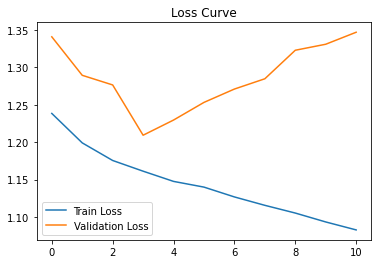

In [109]:
plt.plot(train_loss_list,label="Train Loss")
plt.plot(val_loss_list1,label="Validation Loss")

plt.legend()
plt.title("Loss Curve")

In [105]:
torch.save(classifier,"Only_MLP_"+"epoch{}.pt".format(epoch_sum))

### Predict with test dataset

In [1]:
def predict_se(model, X_test, y_test, dataset_SE_max, plot=True):
    print("[INFO] predicting...")
    X_test = torch.tensor(X_test).to(device)
    preds = model.forward(X_test)
    preds = preds.cpu().detach().numpy().flatten()
    y_test = y_test.flatten()
    diff = abs(preds-y_test)*dataset_SE_max
    # choose how many bins you want here
    num_bins = 30
    # use the histogram function to bin the data
    counts, bin_edges = np.histogram(diff, bins=num_bins)
    # now find the cdf
    cdf = np.cumsum(counts)
    # and finally plot the cdf
    if plot:
        plt.plot(bin_edges[1:], cdf)
        plt.xlabel('Absolute Error (Mbit/Number)')
        plt.ylabel('Count')
        plt.title('Error CDF')
        plt.show()
    diff_percen = abs(preds-y_test)/y_test
    mean = np.mean(abs(diff))
    std = np.std(diff)
    print("[INFO] error mean: {:.3f}, std: {:.3f}".format(mean, std))
    mean = np.mean(abs(diff_percen))
    std = np.std(diff_percen)
    print("[INFO] percentage error mean: {:.3f}, std: {:.3f}" .format(mean, std))
    axis_lim = y_test.mean()*dataset_SE_max*2
    # mean absolute percentage error by sections
    diff_with_y = np.hstack((y_test[:,np.newaxis]*dataset_SE_max, diff_percen[:,np.newaxis]))
    sort_indices = np.argsort(diff_with_y[:,0])
    diff_with_y = diff_with_y[sort_indices,:]
    mape_sections = np.array([1000, 1500, 2500, np.iinfo(int).max])
    mape_sections_mean = np.empty(len(mape_sections))
    idx_section = 0
    diff_id_section = 0
    for i in range(len(diff_with_y)):
        if diff_with_y[i,0]>mape_sections[idx_section] or i == len(diff_with_y)-1:
            mape_sections_mean[idx_section] = np.mean(diff_with_y[diff_id_section:i,1])
            diff_id_section = i
            idx_section = idx_section + 1
    print("[INFO] MAPE by sections: ", np.around(mape_sections_mean, decimals=2))
    if plot:
        plt.figure()
        plt.plot(preds.flatten()*dataset_SE_max, y_test*dataset_SE_max, '.')
        plt.plot([0, axis_lim], [0, axis_lim])
        plt.axis([0, axis_lim, 0, axis_lim])
        plt.xlabel('Prediction (Mbit/Number)')
        plt.ylabel('Ground Truth (Mbit/Number)')
        plt.title('Spectral Efficiency')
        plt.show()

def VisPredict(model,plotOn,X_train,y_train,X_val,y_val,X_test,y_test,dataset_SE_max):
    # make predictions on the testing data
    predict_se(model, X_train, y_train, dataset_SE_max, plotOn)
    predict_se(model, X_val, y_val, dataset_SE_max, plotOn)
    predict_se(model, X_test, y_test, dataset_SE_max, plotOn)
    if plotOn:
        dot_img_file = 'figures/model_1.png'
        #tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

### Predict Results

In [2]:
torch.cuda.empty_cache ()
VisPredict(model,True,X_train,y_train,X_val,y_val,X_test,y_test,y_max[0,0])

NameError: name 'torch' is not defined